In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import torch
import torch.nn as nn
import math
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
!cp /content/drive/MyDrive/bitirme/dataset/augmented_v2_train_data.h5 /content/
!cp /content/drive/MyDrive/bitirme/dataset/val_data_v2.h5 /content/
!cp /content/drive/MyDrive/bitirme/dataset/test_data_v2.h5 /content/

In [9]:
!cp /content/drive/MyDrive/bitirme/dataset/vit_train_data.h5 /content/
!cp /content/drive/MyDrive/bitirme/dataset/vit_val_data.h5 /content/
!cp /content/drive/MyDrive/bitirme/dataset/vit_test_data.h5 /content/

# Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, size: int = 0, max_len: int = 5000):
        if size % 2 != 0:
            raise ValueError(
                "Cannot use sin/cos positional encoding with "
                "odd dim (got dim={:d})".format(size)
            )
        pe = torch.zeros(max_len, size)

        #create a 1D tensor [0, 1, ..., max_len-1]
        #unsqueeze it to add a dimension, making it a 2D tensor of shape (max_len, 1)
        position = torch.arange(0, max_len).unsqueeze(1)

        #Compute frequencies for the sine/cosine functions. (divergence term)
        div_term = torch.exp(
            (torch.arange(0, size, 2, dtype=torch.float) * -(math.log(10000.0) / size))
        )
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, size, max_len]
        super(PositionalEncoding, self).__init__()
        self.register_buffer("pe", pe)
        self.dim = size

    def forward(self, emb):
        # Add positional encodings to word embeddings
        return emb + self.pe[:, : emb.size(1)]

In [23]:
class SignTransformerEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int = 384,  # Original input dimension
        hidden_size: int = 300,
        ff_size: int = 1024,
        num_layers: int = 3,
        num_heads: int = 6,
        dropout: float = 0.1,
        emb_dropout: float = 0.1,
        freeze: bool = False,
    ):
        super().__init__()

        # Input projection to match hidden size
        # 384 -> 512
        self.input_projection = nn.Linear(input_dim, hidden_size)

        # 512 -> 300
        #self.ouput_projection = nn.Linear(hidden_size, 300)


        # Positional encoding with embedding dropout
        self.positional_encoding = PositionalEncoding(
            size=hidden_size
        )

        # Create transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=ff_size,
            dropout=dropout,
            layer_norm_eps = 1e-6,
            batch_first=True,
            norm_first=True
        )

        # Create transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(hidden_size, eps=1e-6)
        )

        # Layer normalization
        #self.norm = nn.LayerNorm(hidden_size, eps=1e-6)

        self.emb_dropout = nn.Dropout(p=emb_dropout)

        # Freeze parameters if specified
        if freeze:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, src, src_key_padding_mask, src_mask=None):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len, input_dim]
            src_mask: Optional attention mask
            src_key_padding_mask: Optional key padding mask
        """
        # Project input to hidden size
        x = self.input_projection(src)

        x = self.positional_encoding(x)

        #Set some of the elements in the tensor to zero
        x = self.emb_dropout(x)

        # Pass through transformer encoder
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)

        #x = self.ouput_projection(x)
        #x = self.norm(x)

        return x

In [6]:
class PretrainingModule(nn.Module):
    def __init__(self, prototypes, sign_dim=300, proto_dim=300, tau_t=0.1, tau_u=0.1):
        super(PretrainingModule, self).__init__()
        self.encoder = SignTransformerEncoder()
        self.sign_dim = sign_dim
        self.prototypes = nn.Parameter(prototypes) #DxU
        self.proto_dim = proto_dim

        #temperature parameters used in the softmax calculations within the forward method
        self.tau_t = nn.Parameter(torch.tensor(tau_t))
        self.tau_u = nn.Parameter(torch.tensor(tau_u))

    def forward(self, sign_features, labels, masks):
        encoded_features = self.encoder(sign_features, masks)  # Shape: (batch_size, T, model_dim)

        encoded_features_norm = F.normalize(encoded_features, dim=-1) # Normalize along the feature dimension
        prototypes_norm = F.normalize(self.prototypes, dim=0)  # Normalize prototypes

        # The torch.einsum operation with the subscripts "btd,du->btu" effectively calculates the
        # dot product between the normalized encoded features and the normalized prototypes.
        # The dot product of two normalized vectors is equivalent to their cosine similarity.
        similarity = torch.einsum("btd,du->btu", encoded_features_norm, prototypes_norm)  # Shape: (batch_size, T, num_prototypes)

        #This line calculates the probability of each frame in the video being associated with a
        #specific prototype, considering the similarities across all frames in the video.
        temporal_prob = F.softmax(similarity / self.tau_t, dim=1)  # Softmax over time

        #This line calculates the probability of each prototype being associated with a specific
        #frame in the video, considering the similarities across all prototypes.
        prototype_prob = F.softmax(similarity / self.tau_u, dim=2)  # Softmax over prototypes

        #localization_matrix creates a heatmap that highlights the temporal locations
        #where specific prototypes are most likely to be active within the video.
        localization_matrix = temporal_prob * prototype_prob  # Shape: (batch_size, T, num_prototypes) Shape kontrol et

        #This line calculates the overall probability of each prototype being present in the video,
        #regardless of its specific temporal location. It aggregates the probabilities over time.
        aggregated_probs = localization_matrix.sum(dim=1)  # Shape: (batch_size, num_prototypes)

        #This line compares the model's predicted prototype probabilities to the true labels
        loss = F.binary_cross_entropy(aggregated_probs, labels)

        return loss, aggregated_probs, temporal_prob

# Train Dataset

In [17]:
import h5py
class MemorySignLanguageDataset(Dataset):
    def __init__(self, hdf5_path):
        # Load everything into memory once.
        with h5py.File(hdf5_path, 'r') as hf:
            self.embeddings = hf['embeddings'][:]  # load entire array into memory
            self.labels = hf['labels'][:]
            self.masks = hf['masks'][:]
        self.length = len(self.embeddings)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Convert to torch tensors on the fly.
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.bool)
        return embedding, label, mask

In [8]:
with open('/content/drive/MyDrive/bitirme/dataset/prototypes.pkl', 'rb') as file:
    prototypes = pickle.load(file)
#UxD to DxU
#U = Number of Unique Prototypes
#D = Embedding Length
prototypes = torch.tensor(prototypes,dtype=torch.float32)
prototypes = prototypes.T.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

<ipython-input-8-9aaee4daa254>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  prototypes = torch.tensor(prototypes,dtype=torch.float32)


In [18]:
# Create the Dataset

train_dataset = MemorySignLanguageDataset('/content/vit_train_data.h5')
val_dataset = MemorySignLanguageDataset('/content/vit_val_data.h5')

# Create the DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training

In [28]:
from torch.optim.lr_scheduler import OneCycleLR

num_epochs = 100
learning_rate = 3e-6

#encoder = SignTransformerEncoder()
model = PretrainingModule(prototypes = prototypes)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
'''
scheduler = OneCycleLR(
    optimizer,
    max_lr=3e-4,  # Peak learning rate
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    anneal_strategy="cos",  # Cosine annealing
    pct_start=0.05,  # Warmup for 5% of training
    div_factor=100,
    final_div_factor=100
) #scheduler from paper
'''
#ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose = True)

# Device Handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PretrainingModule(
  (encoder): SignTransformerEncoder(
    (input_projection): Linear(in_features=384, out_features=300, bias=True)
    (positional_encoding): PositionalEncoding()
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
          )
          (linear1): Linear(in_features=300, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=300, bias=True)
          (norm1): LayerNorm((300,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((300,), eps=1e-06, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((300,), eps=1e-06, elementwise_affine=True)
    )


In [29]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")

Total trainable parameters: 3773174


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

tau_t
tau_u
encoder.input_projection.weight
encoder.input_projection.bias
encoder.transformer_encoder.layers.0.self_attn.in_proj_weight
encoder.transformer_encoder.layers.0.self_attn.in_proj_bias
encoder.transformer_encoder.layers.0.self_attn.out_proj.weight
encoder.transformer_encoder.layers.0.self_attn.out_proj.bias
encoder.transformer_encoder.layers.0.linear1.weight
encoder.transformer_encoder.layers.0.linear1.bias
encoder.transformer_encoder.layers.0.linear2.weight
encoder.transformer_encoder.layers.0.linear2.bias
encoder.transformer_encoder.layers.0.norm1.weight
encoder.transformer_encoder.layers.0.norm1.bias
encoder.transformer_encoder.layers.0.norm2.weight
encoder.transformer_encoder.layers.0.norm2.bias
encoder.transformer_encoder.layers.1.self_attn.in_proj_weight
encoder.transformer_encoder.layers.1.self_attn.in_proj_bias
encoder.transformer_encoder.layers.1.self_attn.out_proj.weight
encoder.transformer_encoder.layers.1.self_attn.out_proj.bias
encoder.transformer_encoder.layers

In [30]:
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize with a very large value
patience = 20  # Number of epochs to wait for improvement
epochs_without_improvement = 0

# Compute splitting indices for the training dataset

"""
n_train = len(train_dataset)
num_parts = 3
indices = list(range(n_train))
part_length = n_train // num_parts  # integer division
"""

# Training and Validation Loop
for epoch in range(num_epochs):
    """
    current_part = epoch % num_parts
    start = current_part * part_length
    # For the last part, include any remainder
    end = n_train if current_part == num_parts - 1 else (current_part + 1) * part_length
    subset_indices = indices[start:end]
    # Create a subset dataset and a corresponding DataLoader for this epoch
    subset_dataset = Subset(train_dataset, subset_indices)
    train_dataloader_subset = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
    """

    # Training Phase
    model.train()
    train_loss = 0.0

    for train_batch_features, train_batch_labels, train_batch_masks in train_dataloader:
        train_batch_features, train_batch_labels, train_batch_masks = train_batch_features.to(device), train_batch_labels.to(device), train_batch_masks.to(device)

        optimizer.zero_grad()  # Clear gradients
        loss, _ , _ = model(train_batch_features, train_batch_labels, train_batch_masks)  # Forward pass
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #Gradient Clipping
        optimizer.step()  # Update parameters
        train_loss += loss.item()
        #scheduler.step()

    # Validation Phase
    model.eval()
    val_loss = 0.0


    with torch.no_grad():  # No gradient computation for validation
        for val_batch_features, val_batch_labels, val_batch_masks in val_dataloader:
            val_batch_features, val_batch_labels, val_batch_masks = val_batch_features.to(device), val_batch_labels.to(device), val_batch_masks.to(device)
            loss, _ , _ = model(val_batch_features, val_batch_labels, val_batch_masks)  # Forward pass
            val_loss += loss.item()


    avg_val_loss = val_loss / len(val_dataloader)
    avg_train_loss = train_loss / len(train_dataloader)

    train_losses.append(avg_train_loss)  # Append training loss
    val_losses.append(avg_val_loss)  # Append validation loss
    #scheduler.step()  # Update learning rate
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f} Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        # You might want to save the best model here:
        #torch.save(model.state_dict(), '/content/drive/MyDrive/dataset/best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break  # Exit the training loop

print("Training completed!")

Epoch [1/100], Training Loss: 0.0231, Validation Loss: 0.0201 Learning Rate: 0.000003
Epoch [2/100], Training Loss: 0.0213, Validation Loss: 0.0192 Learning Rate: 0.000003
Epoch [3/100], Training Loss: 0.0203, Validation Loss: 0.0180 Learning Rate: 0.000003
Epoch [4/100], Training Loss: 0.0190, Validation Loss: 0.0170 Learning Rate: 0.000003
Epoch [5/100], Training Loss: 0.0182, Validation Loss: 0.0167 Learning Rate: 0.000003
Epoch [6/100], Training Loss: 0.0179, Validation Loss: 0.0165 Learning Rate: 0.000003
Epoch [7/100], Training Loss: 0.0176, Validation Loss: 0.0164 Learning Rate: 0.000003
Epoch [8/100], Training Loss: 0.0173, Validation Loss: 0.0162 Learning Rate: 0.000003
Epoch [9/100], Training Loss: 0.0170, Validation Loss: 0.0161 Learning Rate: 0.000003
Epoch [10/100], Training Loss: 0.0168, Validation Loss: 0.0161 Learning Rate: 0.000003
Epoch [11/100], Training Loss: 0.0167, Validation Loss: 0.0161 Learning Rate: 0.000003
Epoch [12/100], Training Loss: 0.0166, Validation Lo

# Loss Visualization

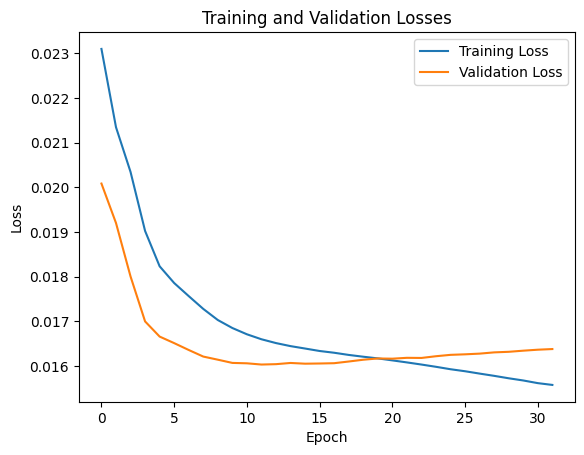

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save Model

In [ ]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, '/content/drive/MyDrive/bitirme/model/model-2layer-256ff-3head-2dropout-constantlr.pth')

In [ ]:
def reset_parameters(model):
       for layer in model.children():
           if hasattr(layer, 'reset_parameters'):
               layer.reset_parameters()
reset_parameters(model)  # Reset parameters of your model

# Load Saved Model

In [ ]:
model = PretrainingModule(prototypes=prototypes)
state_dict = torch.load('/content/drive/MyDrive/bitirme/model/model-1200ff-4head.pth')
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


PretrainingModule(
  (encoder): SignTransformerEncoder(
    (input_projection): Linear(in_features=384, out_features=300, bias=True)
    (positional_encoding): PositionalEncoding()
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
          )
          (linear1): Linear(in_features=300, out_features=1200, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=1200, out_features=300, bias=True)
          (norm1): LayerNorm((300,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((300,), eps=1e-06, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): LayerNorm((300,), eps=1e-06, elementwise_affine=True)
    )


# Metrics

In [32]:
test_dataset = MemorySignLanguageDataset('/content/vit_test_data.h5')
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # No need to shuffle for testing

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
model.eval()
all_temporal_probs = []
all_predictions = []
all_labels = []  # Store ground truth labels
with torch.no_grad():
    for test_batch_features, test_batch_labels, test_batch_masks in test_dataloader:
        test_batch_features, test_batch_labels, test_batch_masks = test_batch_features.to(device), test_batch_labels.to(device), test_batch_masks.to(device)
        _, predicted_probs, temporal_probs = model(test_batch_features, test_batch_labels, test_batch_masks)
        all_temporal_probs.extend(temporal_probs.cpu().numpy())
        all_predictions.extend(predicted_probs.cpu().numpy())  # Store predictions
        all_labels.extend(test_batch_labels.cpu().numpy())  # Store ground truth labels


# Convert predictions to binary (0 or 1) based on a threshold
threshold = 0.2  # Choose an appropriate threshold
all_predictions_binary = (np.array(all_predictions) >= threshold).astype(int)

In [35]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions_binary)
precision = precision_score(all_labels, all_predictions_binary, average='micro')  # Use 'micro' for multi-label
recall = recall_score(all_labels, all_predictions_binary, average='micro')  # Use 'micro' for multi-label
f1 = f1_score(all_labels, all_predictions_binary, average='micro')  # Use 'micro' for multi-label

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.0000
Precision: 0.2481
Recall: 0.0840
F1-score: 0.1255


# Metrics for Individual Glosses

In [ ]:
# Calculate metrics for each pseudo-gloss
all_labels_np = np.array(all_labels)
num_pseudo_glosses = all_labels_np.shape[1]  # Assuming all_labels is a NumPy array
precisions = []
recalls = []
f1s = []
accuracies = []  # List to store accuracies for each pseudo-gloss

for i in range(num_pseudo_glosses):
    # Get predictions and labels for the current pseudo-gloss
    pseudo_gloss_predictions = all_predictions_binary[:, i]
    pseudo_gloss_labels = all_labels_np[:, i]

    # Calculate metrics for the current pseudo-gloss
    precision = precision_score(pseudo_gloss_labels, pseudo_gloss_predictions, zero_division=0)
    recall = recall_score(pseudo_gloss_labels, pseudo_gloss_predictions, zero_division=0)
    f1 = f1_score(pseudo_gloss_labels, pseudo_gloss_predictions, zero_division=0)
    accuracy = accuracy_score(pseudo_gloss_labels, pseudo_gloss_predictions)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)

# Calculate average metrics across all pseudo-glosses
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1s)
avg_accuracy = np.mean(accuracies)  # Calculate average accuracy

# Print the average metrics
print(f"Average Accuracy: {avg_accuracy:.4f}")  # Print average accuracy
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")

KeyboardInterrupt: 

# Predicted and Actual Glosses

In [ ]:
with open('/content/drive/MyDrive/bitirme/dataset/pseudo_gloss_list.pkl', 'rb') as file:
    pseudo_gloss_list = pickle.load(file)

In [ ]:
row_number = 0
for row in all_predictions_binary:
  print("SAMPLE " + str(row_number))
  predicted_glosses = []
  probabilities = []
  frames = []
  column_number = 0
  for column in row:
    if column == 1:
      predicted_glosses.append(pseudo_gloss_list[column_number])
      probabilities.append(all_predictions[row_number][column_number])
      frames.append(all_temporal_probs)
    column_number += 1
  print("predictions: " + ", ".join(predicted_glosses))
  actual_glosses = []
  column_number = 0
  for column in all_labels[row_number]:
    if column == 1:
      actual_glosses.append(pseudo_gloss_list[column_number])
    column_number += 1
  print("actual glosses: " + ", ".join(actual_glosses))
  print("probabilities: " + ", ".join(map(str, probabilities)))
  correct_guesses = 0
  for actual_gloss in actual_glosses:
    if actual_gloss in predicted_glosses: correct_guesses += 1
  print("correct guesses: " + str(correct_guesses) + "/" + str(len(actual_glosses)))
  print("----------------------------------")
  row_number += 1

SAMPLE 0
predictions: gut, auch, morgen, noch, es, tag
actual glosses: erfreulich, nachricht
probabilities: 0.26311147, 0.27760285, 0.24934086, 0.2897297, 0.38936934, 0.3862021
correct guesses: 0/2
----------------------------------
SAMPLE 1
predictions: auch, noch, freundlich, es, sonne
actual glosses: es, scheinen, sonne, häufig
probabilities: 0.31741503, 0.33018708, 0.27700168, 0.48874426, 0.8143406
correct guesses: 2/4
----------------------------------
SAMPLE 2
predictions: auch, morgen, noch, es, nachmittag, dienstag, wechselhaft
actual glosses: samstag, wieder, es, unbeständig
probabilities: 0.3289693, 0.20819917, 0.2169725, 0.3512749, 0.2360647, 0.65876305, 0.39370075
correct guesses: 1/4
----------------------------------
SAMPLE 3
predictions: auch, grad, osten, es, nordosten, sonne, mittwoch
actual glosses: teil, noch, es, nordosten, bayern, freundlichsten
probabilities: 0.32105637, 0.21769996, 0.26559567, 0.3170046, 0.21430755, 0.24832591, 0.6264263
correct guesses: 2/6
----

In [ ]:
drive.flush_and_unmount()

#  Visualizations of the Localization

In [ ]:
!cp /content/drive/MyDrive/bitirme/corpus/PHOENIX-2014-T.test.corpus.csv /content/

Saving PHOENIX-2014-T.test.corpus.csv to PHOENIX-2014-T.test.corpus.csv


In [ ]:
import pandas as pd
test_corpus = pd.read_csv('PHOENIX-2014-T.test.corpus.csv', sep='|') #TEST
sorted_test_corpus = test_corpus.sort_values(by='name')
sorted_test_corpus = sorted_test_corpus.reset_index(drop = True)
sorted_test_corpus = sorted_test_corpus.iloc[:640] #642->640
test_translations = sorted_test_corpus['translation']

In [ ]:
import matplotlib.pyplot as plt
sample_index = 614

sample_labels = all_labels[sample_index]
sample_mask_list = test_masks[sample_index].tolist()
actual_gloss_temporal_probs = []
actual_glosses = []

first_mask_index = sample_mask_list.index(1)
with open('/content/drive/MyDrive/dataset/pseudo_gloss_list.pkl', 'rb') as file:
    pseudo_gloss_list = pickle.load(file)

for (index, value) in enumerate(sample_labels):
  if value == 1:
    actual_glosses.append(pseudo_gloss_list[index])
    actual_gloss_temporal_probs.append(all_temporal_probs[sample_index].T[index])

actual_gloss_temporal_probs = np.array(actual_gloss_temporal_probs)

actual_gloss_temporal_probs_including_mask = torch.tensor(actual_gloss_temporal_probs[:,:], dtype=torch.float32)
actual_gloss_temporal_probs = torch.tensor(actual_gloss_temporal_probs[:,:first_mask_index], dtype=torch.float32)

maximum_probability_columns = torch.argmax(actual_gloss_temporal_probs, dim=1).tolist()
maximum_probability_columns_including_mask = torch.argmax(actual_gloss_temporal_probs_including_mask, dim=1).tolist()

maximum_probability_columns_to_label = []

actual_glosses_to_label = []
for gloss_index in range(len(maximum_probability_columns_including_mask)):
  if(maximum_probability_columns_including_mask[gloss_index] <= first_mask_index):
    actual_glosses_to_label.append(actual_glosses[gloss_index])
    maximum_probability_columns_to_label.append(maximum_probability_columns_including_mask[gloss_index])

fig, ax = plt.subplots(figsize=(10,100))
ax.set_title(test_translations[sample_index])
im = ax.imshow(actual_gloss_temporal_probs, aspect=2, cmap='gray')

# Show all ticks and label them with the respective list entries
ax.set_yticks(range(len(actual_glosses)), labels=actual_glosses)

ax.set_xticks(maximum_probability_columns_to_label)
ax.set_xticklabels(actual_glosses_to_label, rotation=45, ha="right")

fig.tight_layout()
plt.show()

NameError: name 'test_masks' is not defined